# Preproc

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../../../raw_data/2011_2021_caluire_phys_v0.csv')
df = df[['DatePrel', '1340']]
df['DatePrel'] = pd.to_datetime(df['DatePrel'])
df['month'] = df['DatePrel'].dt.month
df['year'] = df['DatePrel'].dt.year
df.groupby(['year', 'month'], as_index = False).mean()
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = 1), format = '%Y%m')
df = df.drop(columns = ['DatePrel', 'month', 'year'])
df = df.set_index('date')
df = df.rename(columns = {'1340' : 'nitrates'})
df = df.groupby(['date']).mean()
df = df.asfreq(freq = 'MS', method = 'pad')
#df.head(12)

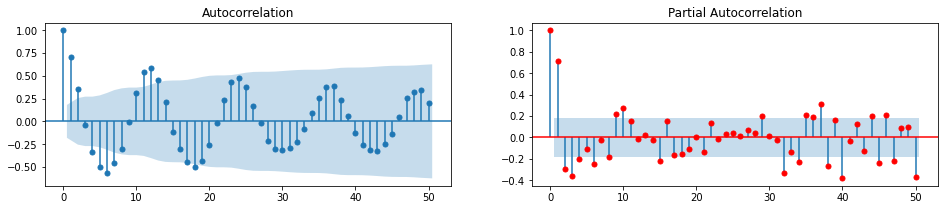

In [3]:
# ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.nitrates, lags=50, ax=axes[0]);
plot_pacf(df.nitrates, lags=50, ax=axes[1], color='r');

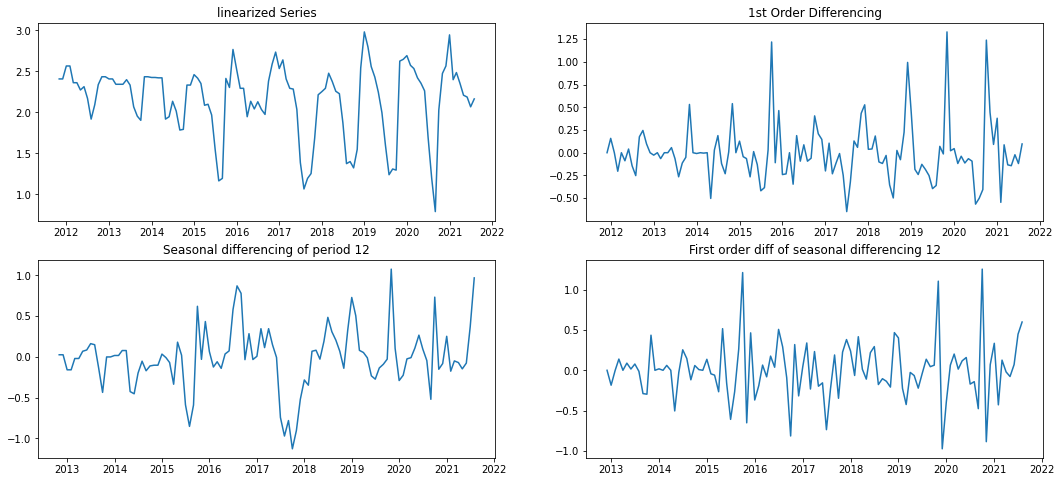

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.nitrates)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [5]:
result_mul = seasonal_decompose(df['nitrates'], model = 'multiplicative', period = 12)

In [6]:
def differentials(df):
    zero_diff = df.nitrates
    first_order_diff = df.nitrates.diff(1)
    second_order_diff = df.nitrates.diff(1).diff(1)
    return zero_diff, first_order_diff, second_order_diff
    
def plot_differentials(df):
    
    diffs = differentials(df)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(diffs[0]); ax1.set_title('Original Series')
    ax2.plot(diffs[1]); ax2.set_title('1st Order Differencing')
    ax3.plot(diffs[2]); ax3.set_title('2nd Order Differencing');
    
def deseasonalized(df):
    df['deseasonalized'] = df.nitrates.values/result_mul.seasonal
    df['linearized'] = np.log(df['deseasonalized'])
    return df['deseasonalized'], df['linearized']

def plot_deseasonalized(df):
    deseason = deseasonalized(df)
    plt.figure(figsize=(15,4));
    plt.subplot(1,2,1); plt.plot(deseason[0]);
    plt.title('Deseasonalized', fontsize=16);
    plt.subplot(1,2,2); plt.plot(deseason[1])
    plt.title('Deseasonalized and Linearized', fontsize=16);

In [7]:
train = deseasonalized(df)[1][:89]
test = deseasonalized(df)[1][89:]

# Model

In [8]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=3, max_d=2, start_q=0, max_q=3,
                       start_P=0, max_P=3, max_D=2, start_Q=0, max_Q=3, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=27.852, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-19.197, Time=0.70 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-7.456, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=396.499, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-21.060, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-19.257, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-19.925, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-19.742, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-9.116, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-18.952, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.067 seconds


In [9]:
# Build Model
sarima = SARIMAX(train, order=(1, 0, 0),seasonal_order=(0,0,0,12))
sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.36223D-02    |proj g|=  3.64115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     39      2     0     0   1.118D-04  -3.362D-02
  F =  -3.3622480035981443E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [10]:
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()
confidence_int

,lower linearized,upper linearized
2019-04-01,1.880984,2.774884
2019-05-01,1.685384,2.946266
2019-06-01,1.533652,3.073907
2019-07-01,1.404831,3.178761
2019-08-01,1.290780,3.268969
2019-09-01,1.187312,3.348720
2019-10-01,1.091930,3.420506
2019-11-01,1.003005,3.485959
2019-12-01,0.919400,3.546214
2020-01-01,0.840286,3.602099


In [11]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [12]:
# Reconstruct by taking exponential
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower log']).values
upper_recons = np.exp(confidence_int['upper log']).values

plot_forecast(forecast_recons, np.exp(train), np.exp(test), upper = upper_recons, lower=lower_recons)

KeyError: 'lower log'